In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import ipywidgets as widgets
import logging
logging.basicConfig(level=logging.INFO)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lane_detector import CameraCalibration
from lane_detector import PerspectiveTransformation

cc = CameraCalibration(params_load_path='../data/camera_cal/output_params.json')
mtx, dist = cc.get_camera_params()
pp = PerspectiveTransformation()

INFO:CameraUtils:Camera params loaded and ready to use


In [2]:
def show_n_m_grid(data, cmap='gray', rows=4, cols=2, axis='off', image=True):
    
    f, axes = plt.subplots(rows, cols, figsize=(20,20) )
    f.tight_layout()
    for idx, datum in enumerate(data):
        row = idx // cols
        col = idx % cols
        if axis=='off':
            axes[row, col].axis('off')
        if image==True:
            axes[row, col].imshow(datum, cmap=cmap, aspect="auto")
        else:
            axes[row, col].plot(datum)
            


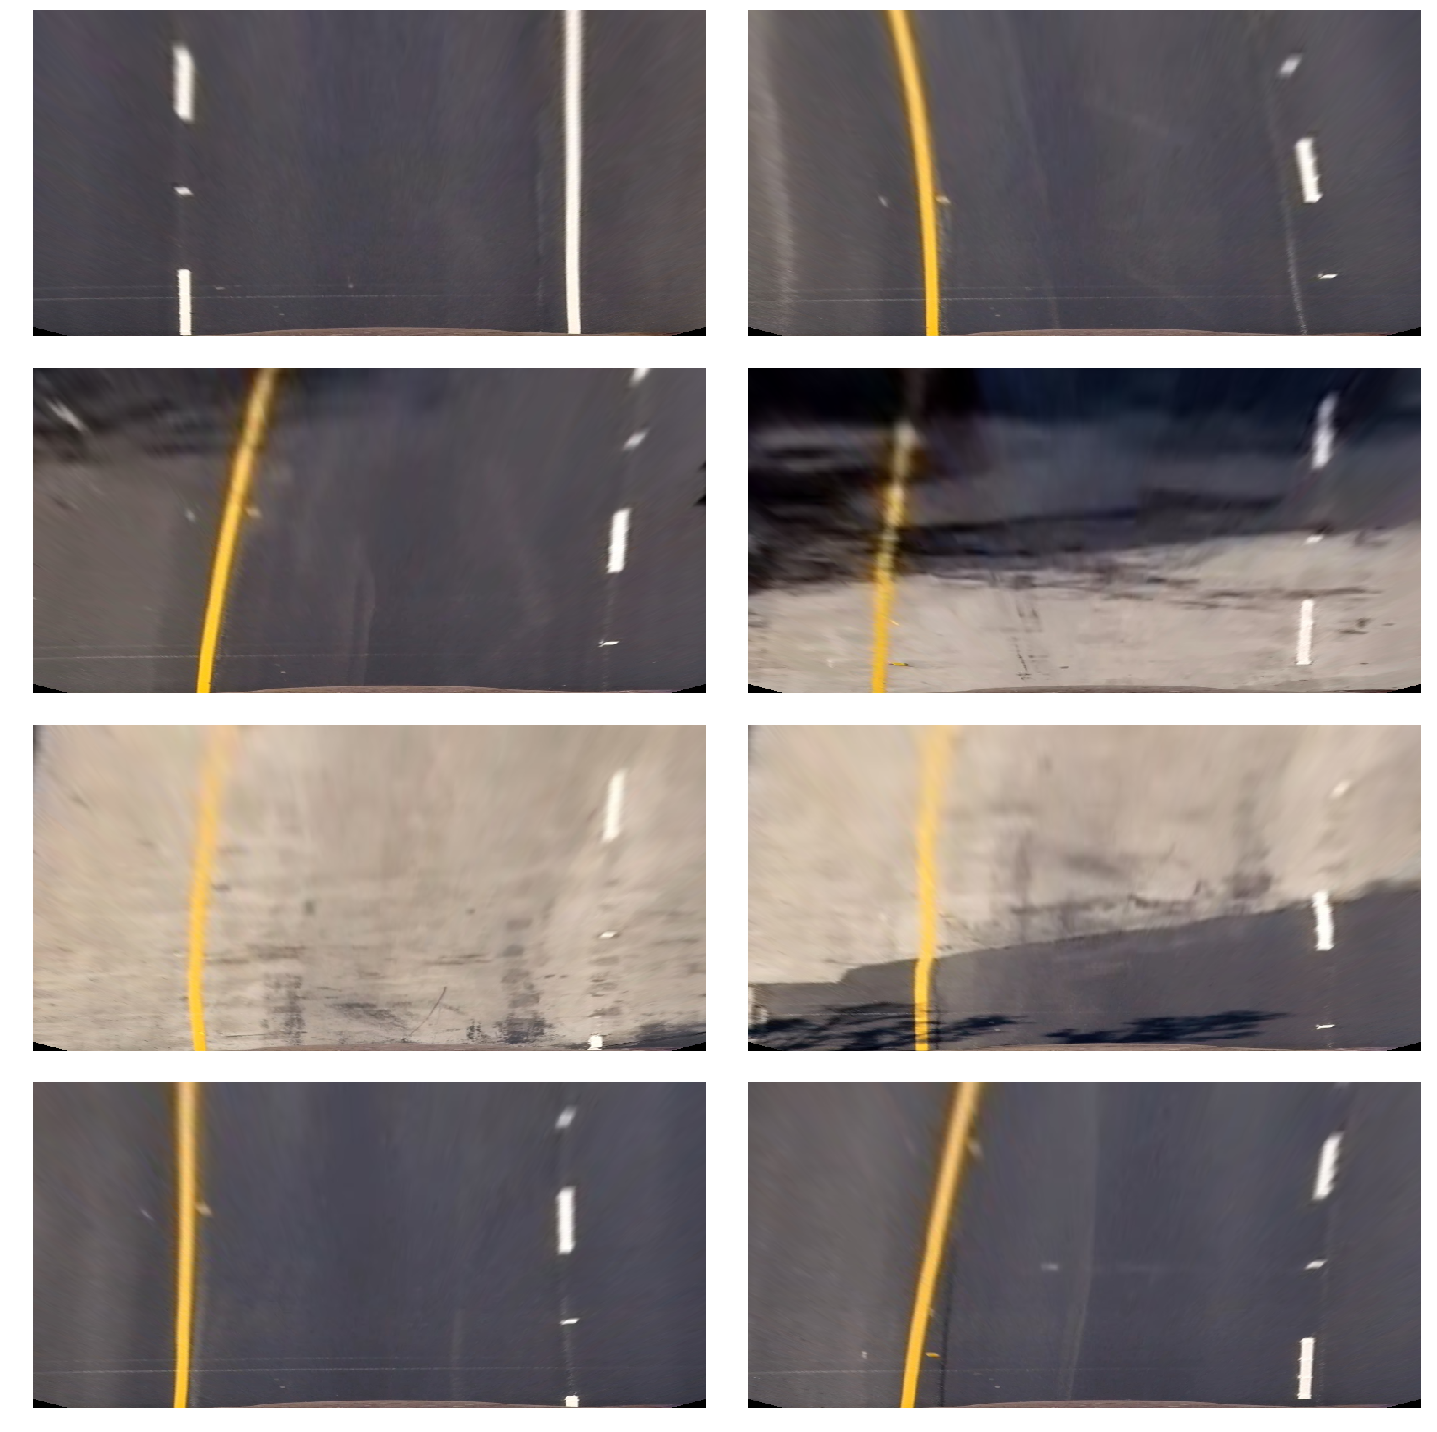

In [17]:
test_images_dir = '../data/test_images/'
test_images = [ os.path.join(test_images_dir, i) for i in os.listdir(test_images_dir)]
distorted_images = [mpimg.imread(i) for i in test_images]

WARPED_IMG_SHAPE = pp.get_destination_image_size()[::-1]
UNWARPED_IMG_SHAPE = (1280, 720) 

corrected_images = [cc.undistort_image(i) for i in distorted_images]
warped_images = [pp.warp_image(i, WARPED_IMG_SHAPE) for i in corrected_images]

show_n_m_grid(warped_images, axis='off')

In [4]:
small_kernel = np.ones((7,7), np.uint8)
def combine_s_v(image, min_val=200, max_val=255):
    '''
    Given a color image, converts it to HSV color scale,
    discards H channel and replaces with V channel and 
    takes a mean of all three channels then applies a 
    threshold to create a masked binary image
    '''
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    v_channel = cv2.dilate(v_channel, small_kernel, iterations=2)
    
    combined = np.mean(np.stack((s_channel, v_channel, v_channel), axis=2), 2)
    combined = cv2.inRange(combined, min_val, max_val)
    
    return combined



s_v_slider = widgets.IntRangeSlider(value=[165, 255], min=0, max=255, step=1,
                                    description='Threshold S & V:', continuous_update=False,
                                    orientation='horizontal', readout=True, readout_format='d')
display(s_v_slider)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


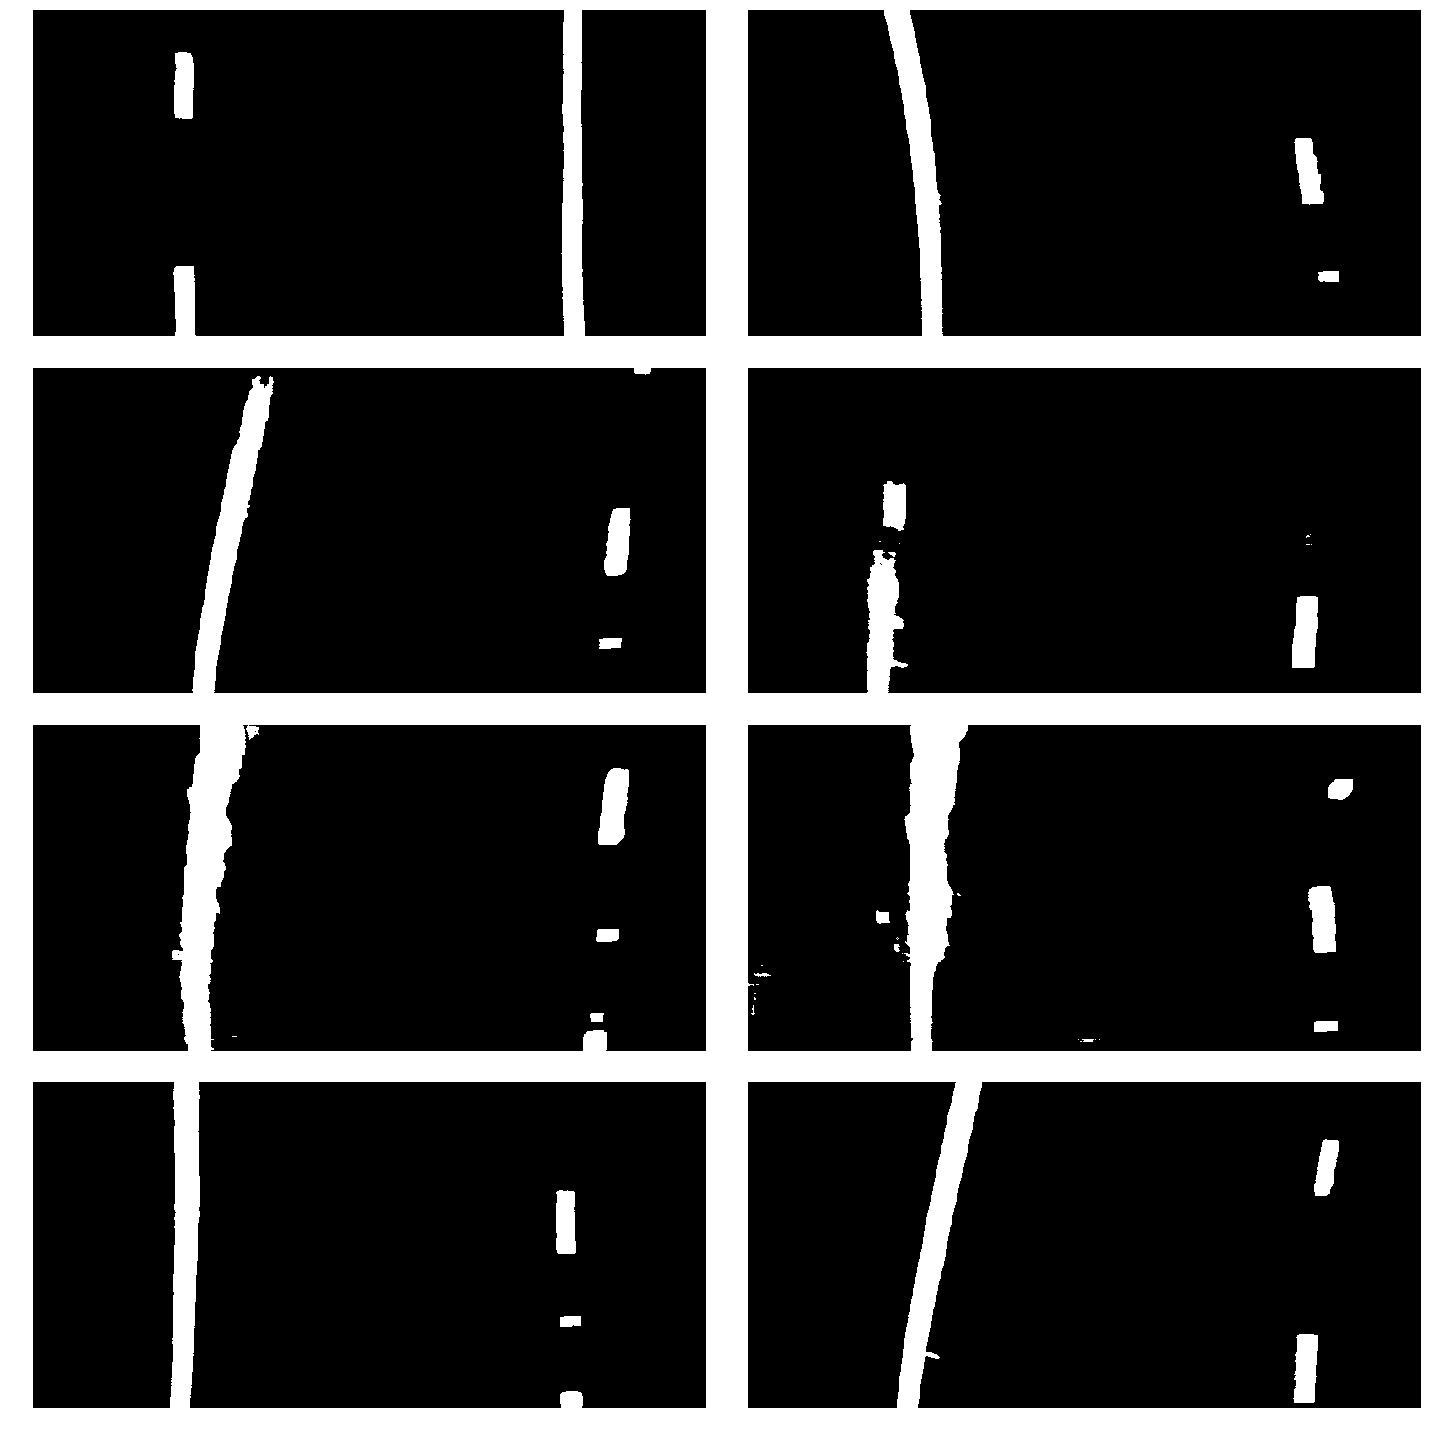

In [18]:
# s_v_slider.value
masked_s_v = [combine_s_v(i, s_v_slider.value[0] , s_v_slider.value[1]) for i in warped_images]
show_n_m_grid(masked_s_v, axis='off')

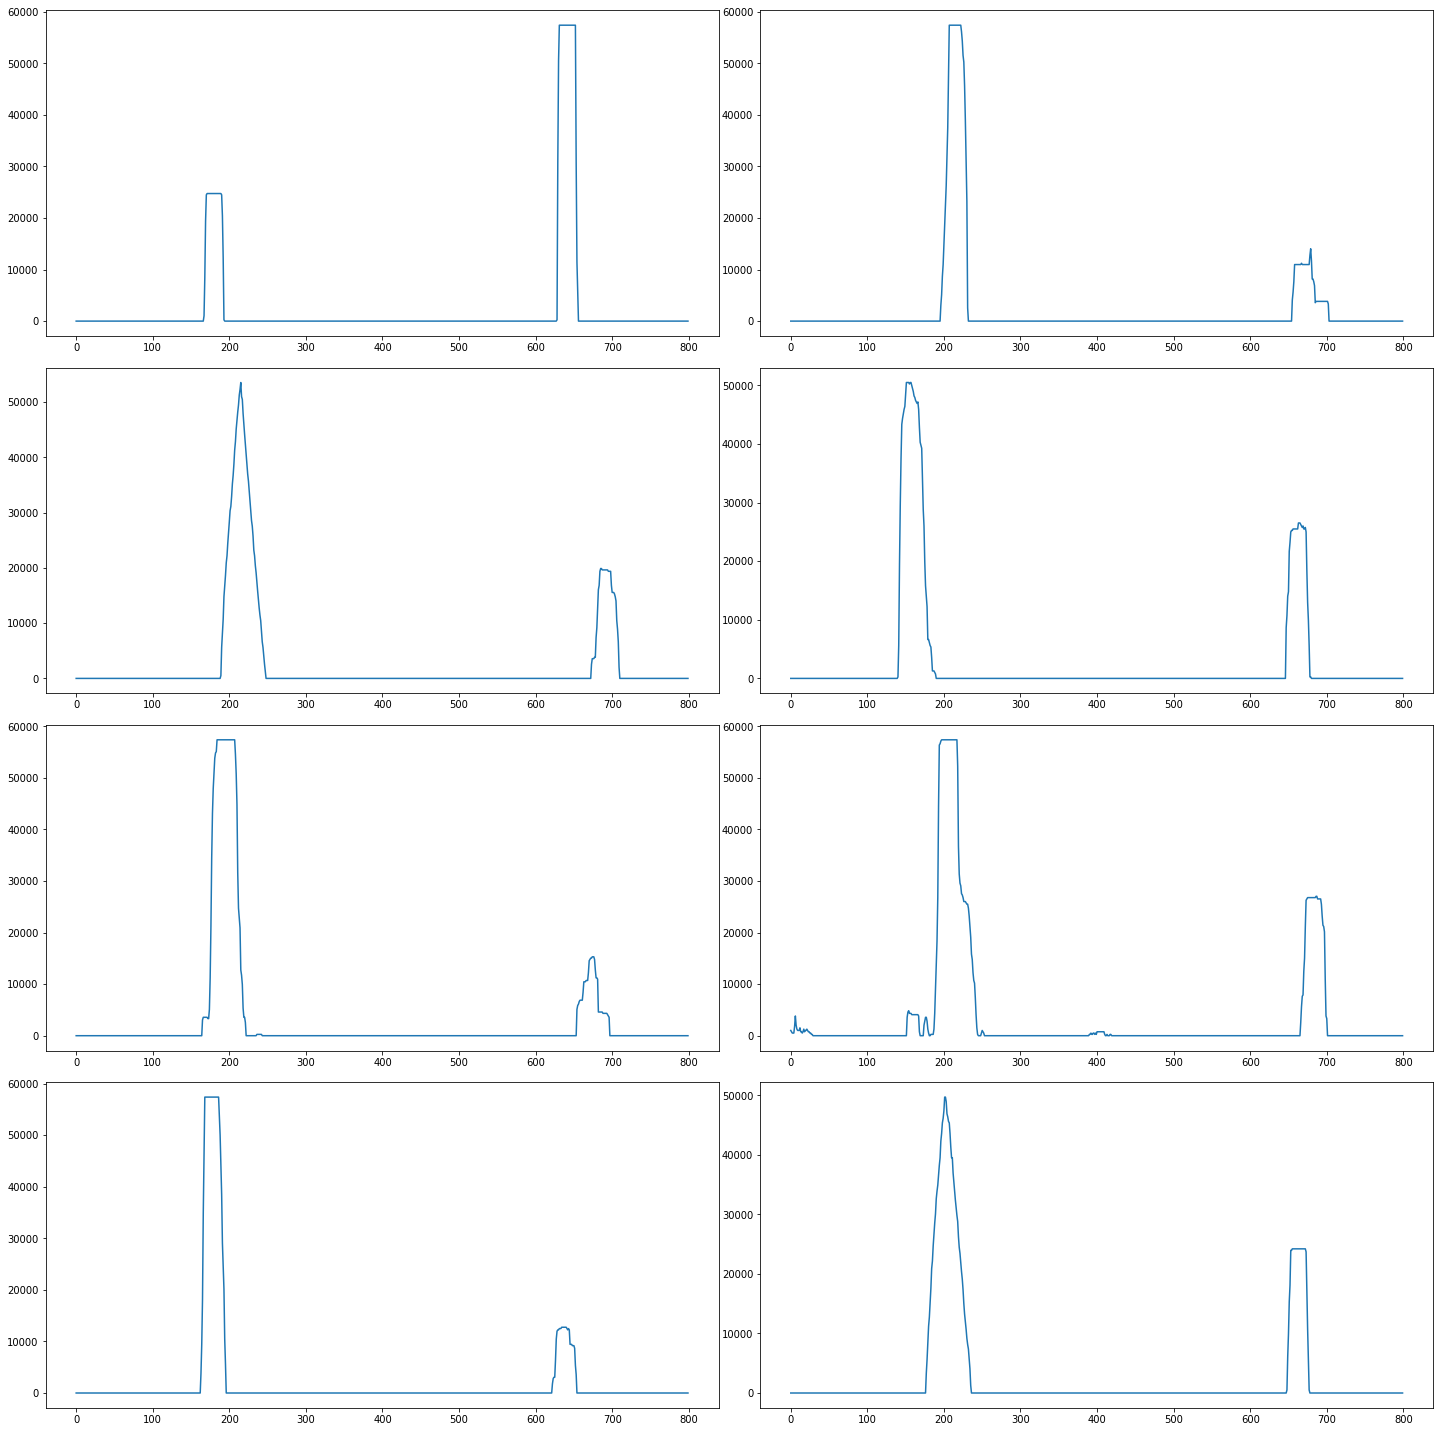

In [6]:

histograms = [ np.sum(img[img.shape[0]//2:,:], axis=0) for img in masked_s_v ]
show_n_m_grid(histograms, image=False, axis='on')


In [7]:
def get_lane_pixels(image, margin=75):
    '''
        Given a binary image with lane lines filtered, find the base of the lane lines
        and get all white pixels in the column starting from that base, around a window of 
        width "margin" on either side
    '''
    image_h_center = int(image.shape[1] / 2) # Horizontal center of the image
    image_v_center = int(image.shape[0] / 2) # Vertical center of the image
    
    # Add all pixels in each column of the image & pick the biggest to either side of the 
    # iage midpoint
    histogram = np.sum(image[image_v_center:, :], axis=0)
    
    left_base = np.argmax(histogram[:image_h_center])
    right_base = np.argmax(histogram[image_h_center:]) + image_h_center
    
    # Extract columns surronding the left and the right of the lane base
    left_min = max(left_base - margin, 0)
    left_max = min(left_base + margin, image_h_center)
    
    right_min = max(right_base - margin, image_h_center)
    right_max = min(right_base + margin, image.shape[1])
    
    left_lane_roi = image[:, left_min : left_max]
    right_lane_roi = image[:, right_min: right_max]
    
    left_indices_y, left_indices_x = np.where(left_lane_roi==255)
    left_indices_x += left_min  # Add offset back
    
    right_indices_y, right_indices_x = np.where(right_lane_roi==255)
    right_indices_x += right_min  # Add offset back
    return ((left_indices_y, left_indices_x), (right_indices_y, right_indices_x))

In [8]:
def fit_poly_line(left_pixels):
    y, x = left_pixels
    return np.polyfit(y, x, deg=2)

In [9]:
def draw_lane_lines(binary_image, orig_image, perspective_transformer):
    
    left_pixels, right_pixels = get_lane_pixels(binary_image)
    left_fit = fit_poly_line(left_pixels)
    right_fit = fit_poly_line(right_pixels)
#     print (left_fit, left_fit.shape)
    out_img = zeros
    out_img = np.dstack((binary_image, binary_image, binary_image))
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line_to_draw = np.int32(list(zip(left_fitx, ploty)))
    right_line_to_draw = np.int32(list(zip(right_fitx, ploty)))
    
    center_line = np.int32((left_line_to_draw + right_line_to_draw)/2)
    
        
    lane_mask = np.int32([left_line_to_draw[0],
                          right_line_to_draw[0],
                          right_line_to_draw[-1],
                          left_line_to_draw[-1]
                         ])
    cv2.fillPoly(out_img, [lane_mask], color=(0, 180, 0))
    cv2.polylines(out_img, [left_line_to_draw], False, color=(255,0,0), thickness=25)
    cv2.polylines(out_img, [right_line_to_draw], False, color=(0,0,255), thickness=25)
    cv2.polylines(out_img, [center_line], False, color=(255,0,255), thickness=5)


    unwarped_lane_mask = pp.unwarp_image(out_img, (orig_image.shape[1],
                                                   orig_image.shape[0]))

    final_image = cv2.addWeighted(orig_image, 1, unwarped_lane_mask, 0.8, 0)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_pixels[0] * ym_per_pix, left_pixels[1] * xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(right_pixels[0] * ym_per_pix, right_pixels[1] * xm_per_pix, deg=2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    image_h_center = binary_image.shape[1] / 2
    car_h_center = (left_line_to_draw[-1][0] + right_line_to_draw[-1][0]) / 2
    offset = (image_h_center - car_h_center) * xm_per_pix
    
    # print(round(offset, 2))
    return (final_image, out_img)


In [15]:
images = [draw_lane_lines(masked_s_v[i], corrected_images[i], pp) for i in range(len(masked_s_v))]
debug_images = [i[1] for i in images]
final_images = [i[0] for i in images]

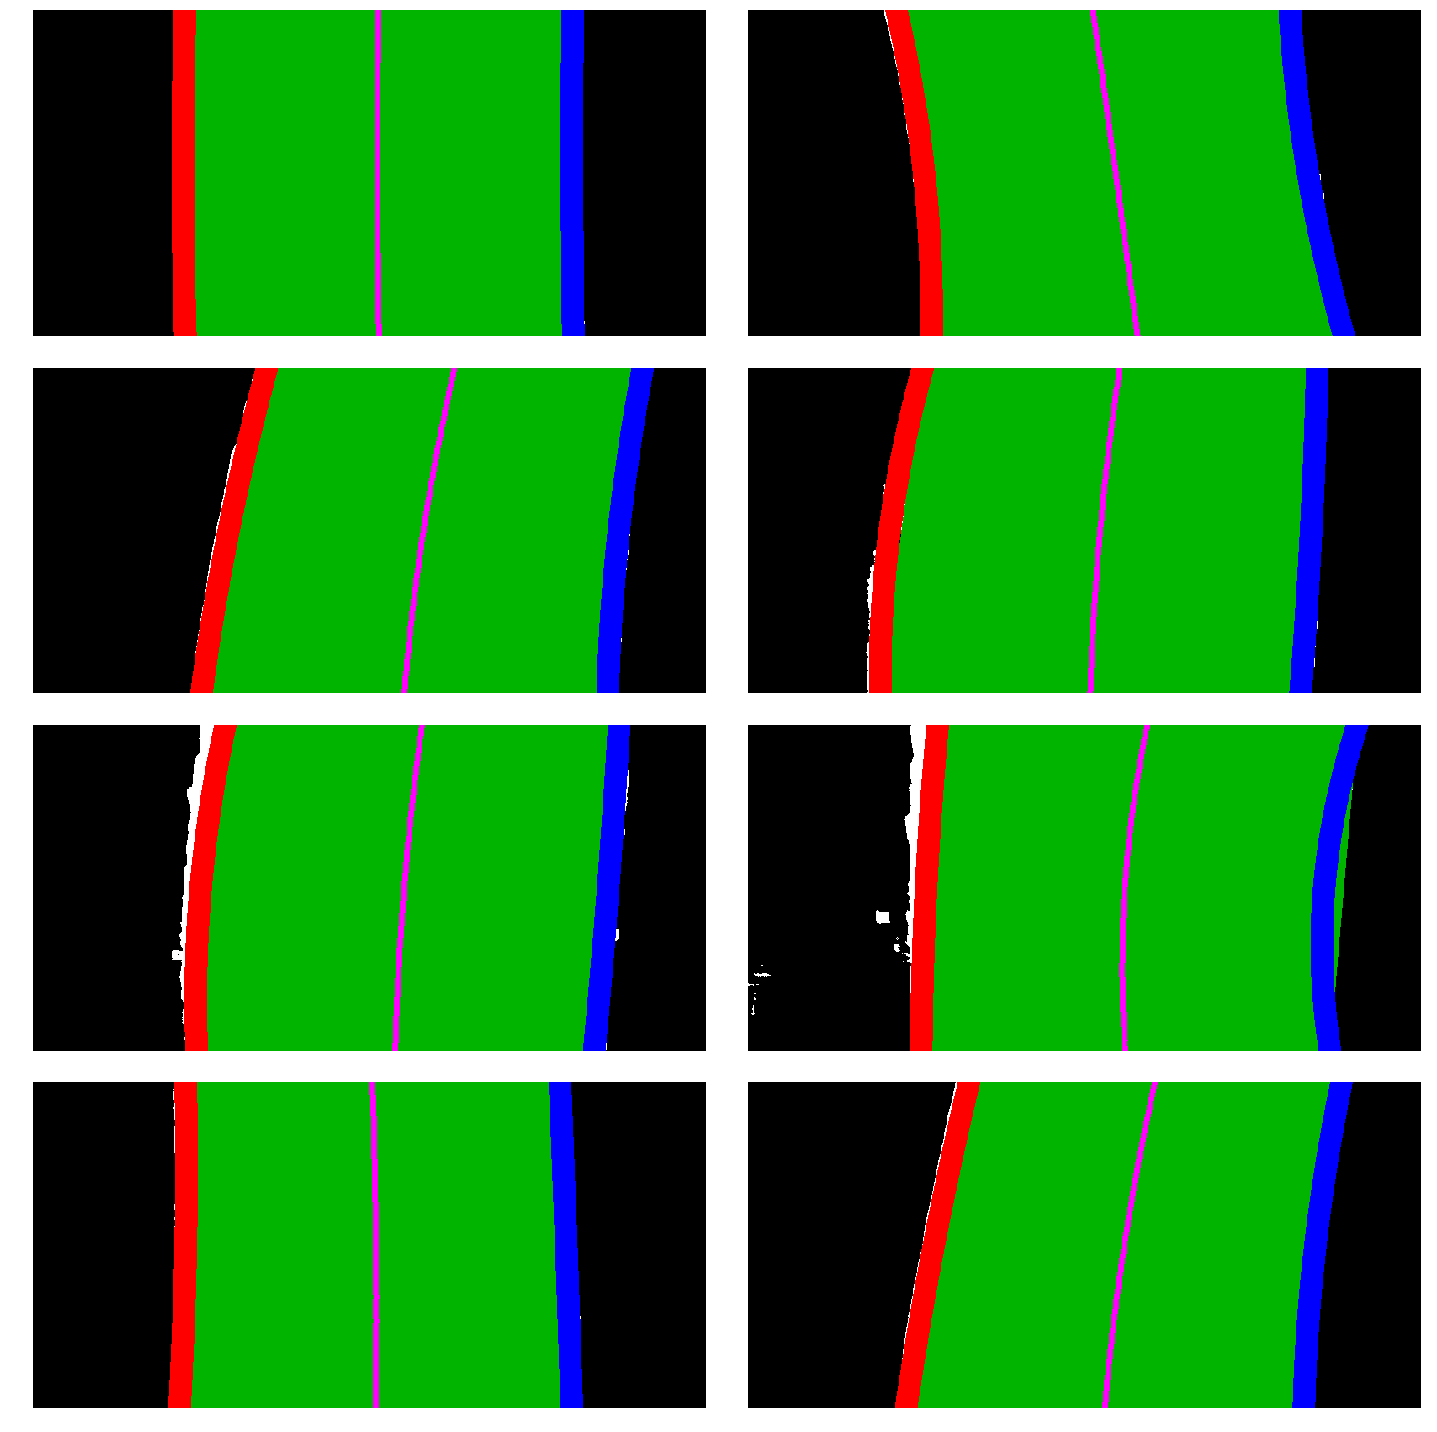

In [16]:
show_n_m_grid(debug_images)

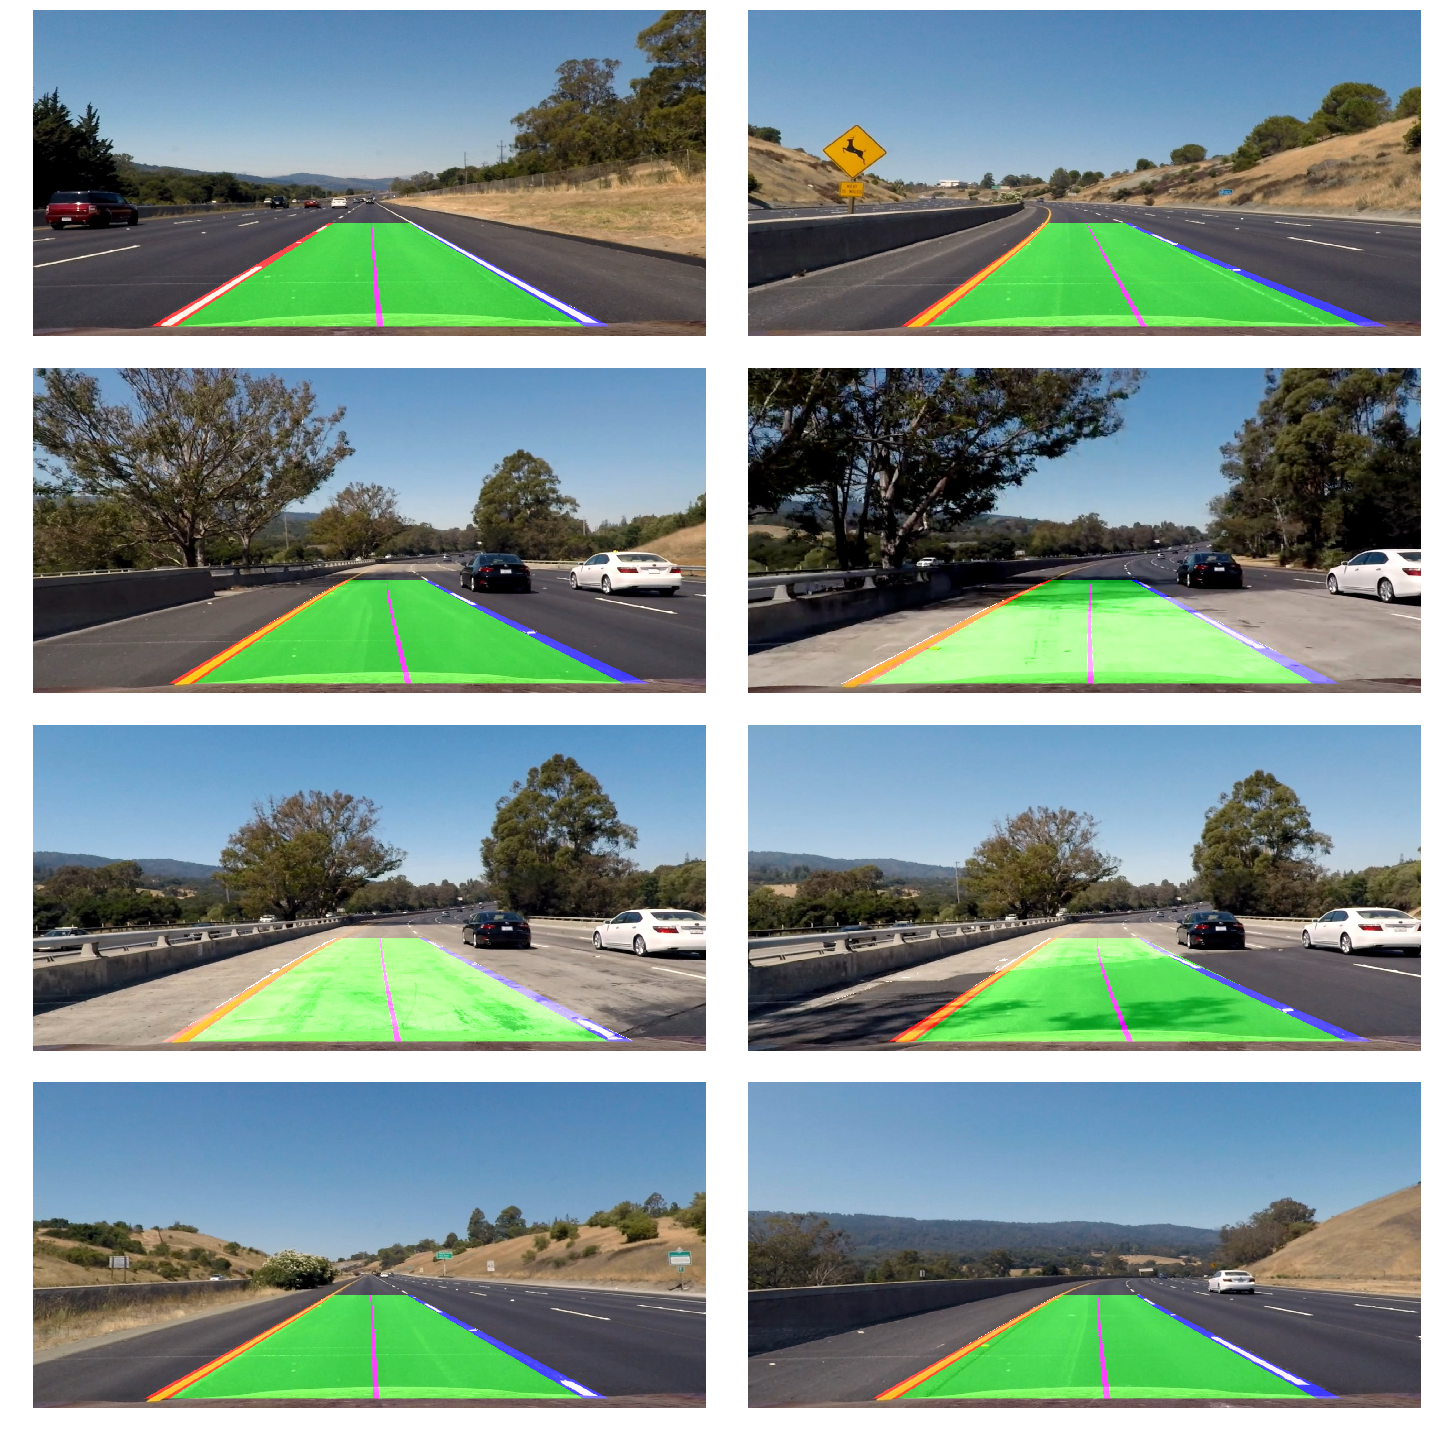

In [19]:
show_n_m_grid(final_images)